In [2]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
LOG.propagate = False

In [44]:
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2025-05-06 11:24:12,821 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:81:04:26:a3:64


2025-05-06 11:24:16,657 | INFO     |: Connected to c0:81:04:26:a3:64


In [6]:
ble.disconnect()

Exception: Not connected to a BLE device

In [9]:
ble.send_command(CMD.PING, "")

In [10]:
s = ble.receive_string(ble.uuid['RX_STRING'])
print(s)

PONG


In [12]:
ble.send_command(CMD.SET_PID_GAINS, "0.09|0.0005|0.01")

In [11]:
ble.send_command(CMD.SET_PID_GAINS, "2.5|0.02|0.7")

In [70]:
ble.send_command(CMD.SET_SETPOINT, "90")

In [47]:
ble.send_command(CMD.START_PID, "")

2025-05-06 11:24:41,039 | INFO     |: Disconnected from A1C0DD95-B611-6CFA-AF80-6BCF50487F59


In [46]:
ble.send_command(CMD.STOP_PID, "")

In [177]:
results = []
# ble.stop_notify(ble.uuid['RX_STRING'])
def notification_handler(uuid, byte_array):
    time, tof, pwm, kf = ble.bytearray_to_string(byte_array).split('|')
    results.append([float(time), float(tof), int(pwm), float(kf)])

ble.start_notify(ble.uuid['RX_STRING'], notification_handler)
ble.send_command(CMD.SEND_PID_DATA, "")

In [54]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [178]:
print(results)

[[10.0, 183.0, -255, 183.0], [17.0, 183.0, -255, 183.0], [22.0, 175.0, -255, 176.757], [29.0, 176.0, -255, 176.757], [31.0, 176.0, -255, 176.757], [41.0, 170.0, -255, 176.704], [49.0, 176.0, -255, 176.704], [51.0, 176.0, -255, 176.704], [61.0, 177.0, -255, 186.759], [65.0, 186.0, -255, 186.759], [67.0, 186.0, -255, 186.759], [75.0, 186.0, -255, 186.759], [77.0, 186.0, -255, 186.759], [83.0, 179.0, -255, 194.76], [86.0, 194.0, -255, 194.76], [93.0, 194.0, -255, 194.76], [95.0, 194.0, -255, 194.76], [99.0, 194.0, -255, 194.76], [105.0, 186.0, -255, 205.649], [108.0, 205.0, -255, 205.649], [110.0, 205.0, -255, 205.649], [113.0, 205.0, -255, 205.649], [116.0, 205.0, -255, 205.649], [126.0, 166.0, -255, 195.807], [129.0, 195.0, -255, 195.807], [132.0, 195.0, -255, 195.807], [134.0, 195.0, -255, 195.807], [137.0, 195.0, -255, 195.807], [140.0, 195.0, -255, 195.807], [150.0, 178.0, -255, 205.568], [153.0, 205.0, -255, 205.568], [156.0, 205.0, -255, 205.568], [158.0, 205.0, -255, 205.568], [16

In [115]:
import csv
import datetime

# Generate filename with timestamp to avoid overwriting
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"robot_data_{timestamp}.csv"

with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    # Write header
    csvwriter.writerow(['Time (ms)', 'Distance (mm)', 'PWM'])
    # Write all data rows
    csvwriter.writerows(results)

print(f"Data saved to {filename}")

Data saved to robot_data_20250408_144518.csv


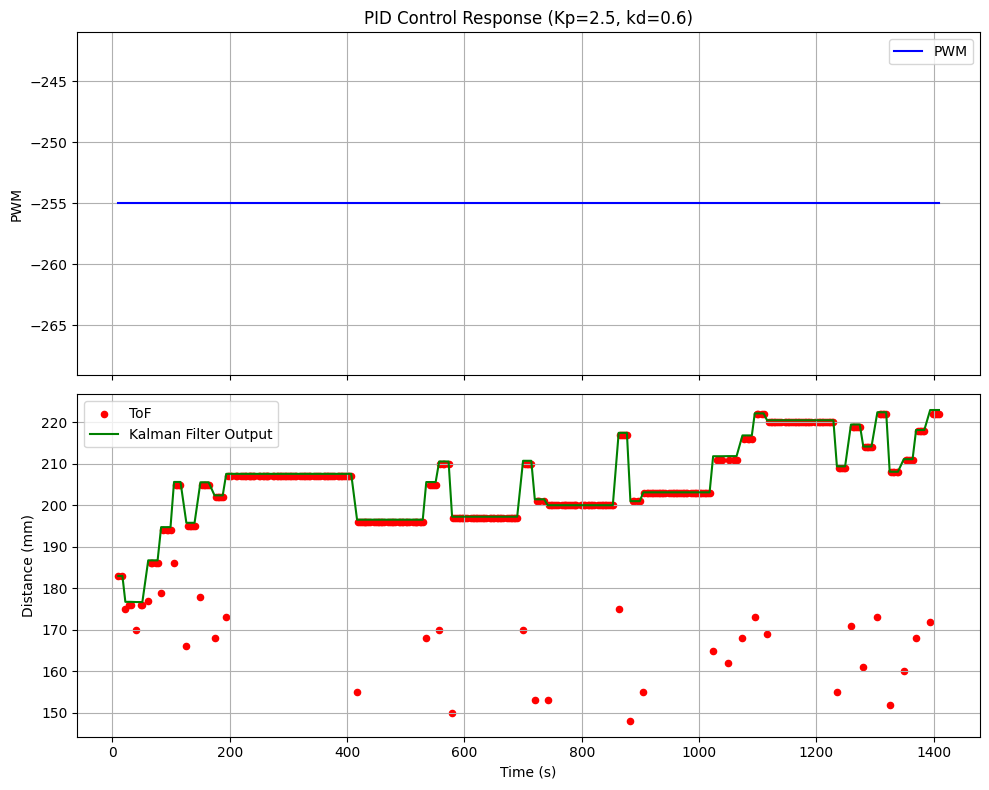

2025-04-08 15:47:25,476 | INFO     |: Disconnected from A1C0DD95-B611-6CFA-AF80-6BCF50487F59


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert results to numpy array for easier handling
data = np.array(results)
time = data[:, 0]
tof = data[:, 1]
pwm = data[:, 2]
kf = data[:, 3]

# Create figure with two subplots sharing x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot PWM vs Time
ax1.plot(time, pwm, 'b-', label='PWM')
ax1.set_ylabel('PWM')
ax1.set_title('PID Control Response (Kp=2.5, kd=0.6)')
ax1.grid(True)
ax1.legend()

# Plot ToF vs Time
ax2.scatter(time, tof, color='r', s=20, label='ToF')
# plt.plot(time, tof, 'r-', label='ToF') 
ax2.plot(time, kf, 'g-', label='Kalman Filter Output')

ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Distance (mm)')
# Set y-axis ticks in steps of 100
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()